<a href="https://colab.research.google.com/github/dominicfanucchi/aai-530_group3/blob/main/LSTM_Vehicle_Count_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Time-Series Vehicle Count Prediction Notebook
Names: Dominic Fanucchi, Daniel Grant, Isaack Karanja   
Date:    February 26, 2024
- This model will predict vehicle counts per hour for each day of the week.




# Setup

In [ ]:
!pip install datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
dataset = load_dataset(
    "mugithi/down_sampled_file_traffic_dataset",
    data_files={
        "train": "data/train-00000-of-00001.parquet",
        "test": "data/test-00000-of-00001.parquet"
    }
)

# Data Preparation and Preprocessing

In [4]:
train_df = dataset['train'].to_pandas()
test_df = dataset['test'].to_pandas()

In [5]:
# sort by TIMESTAMP
train_df['TIMESTAMP'] = pd.to_datetime(train_df['TIMESTAMP'])
test_df['TIMESTAMP'] = pd.to_datetime(test_df['TIMESTAMP'])
train_df.sort_values(by='TIMESTAMP', inplace=True)
test_df.sort_values(by='TIMESTAMP', inplace=True)

In [6]:
# extract hour, day, and month as new columns
train_df['Hour'] = train_df['TIMESTAMP'].dt.hour
train_df['Date_no'] = train_df['TIMESTAMP'].dt.day
train_df['Month'] = train_df['TIMESTAMP'].dt.month
train_df['Day'] = train_df['TIMESTAMP'].dt.day_name()

test_df['Hour'] = test_df['TIMESTAMP'].dt.hour
test_df['Date_no'] = test_df['TIMESTAMP'].dt.day
test_df['Month'] = test_df['TIMESTAMP'].dt.month
test_df['Day'] = test_df['TIMESTAMP'].dt.day_name()

In [7]:
# group by the new columns and sum the vehicle counts
train_hourly = train_df.groupby(['Day', 'Date_no', 'Month', 'Hour']).agg({'vehicleCount': 'sum'}).reset_index()
test_hourly = test_df.groupby(['Day', 'Date_no', 'Month', 'Hour']).agg({'vehicleCount': 'sum'}).reset_index()

In [8]:
# normalize the vehicle counts
scaler = MinMaxScaler()
train_hourly['vehicleCount_scaled'] = scaler.fit_transform(train_hourly[['vehicleCount']])
test_hourly['vehicleCount_scaled'] = scaler.transform(test_hourly[['vehicleCount']])

In [9]:
print(test_hourly.head())

      Day  Date_no  Month  Hour  vehicleCount  vehicleCount_scaled
0  Friday        6      6     0            23             0.005802
1  Friday        6      6     1            21             0.005298
2  Friday        6      6     2            86             0.021695
3  Friday        6      6     3            78             0.019677
4  Friday        6      6     4           638             0.160949


In [10]:
# prepare the features and labels
X_train = train_hourly[['Hour', 'Date_no', 'Month']]
y_train = train_hourly['vehicleCount_scaled']
X_test = test_hourly[['Hour', 'Date_no', 'Month']]
y_test = test_hourly['vehicleCount_scaled']

In [11]:
# one-hot encode 'Day' feature in both training and test sets
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_train = one_hot_encoder.fit_transform(train_hourly[['Day']])
one_hot_test = one_hot_encoder.transform(test_hourly[['Day']])

In [12]:
# concatenate one-hot encoded 'Day' feature with other features
numerical_features_train = train_hourly[['Hour', 'Date_no', 'Month']].values
numerical_features_test = test_hourly[['Hour', 'Date_no', 'Month']].values

In [13]:
# combine numerical and one-hot encoded categorical features for LSTM input
train_features = np.concatenate([numerical_features_train, one_hot_train], axis=1)
test_features = np.concatenate([numerical_features_test, one_hot_test], axis=1)

In [14]:
sequence_length = 5  # changeable
def create_sequences(input_data, target_column, sequence_length):
    X, y = [], []
    for i in range(len(input_data) - sequence_length):
        X.append(input_data[i:(i + sequence_length)])
        y.append(target_column[i + sequence_length])
    return np.array(X), np.array(y)

In [15]:
train_sequences = create_sequences(train_features, train_hourly['vehicleCount_scaled'].values, sequence_length)
test_sequences = create_sequences(test_features, test_hourly['vehicleCount_scaled'].values, sequence_length)

In [16]:
X_train, y_train = train_sequences
X_test, y_test = test_sequences
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Training

In [29]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# LSTM model using search parameters
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# compile
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
batch_size = 32
epochs = 100
model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/100
68/68 [==============================] - 6s 21ms/step - loss: 0.0479 - val_loss: 0.0444
Epoch 2/100
68/68 [==============================] - 0s 7ms/step - loss: 0.0218 - val_loss: 0.0325
Epoch 3/100
68/68 [==============================] - 0s 7ms/step - loss: 0.0172 - val_loss: 0.0299
Epoch 4/100
68/68 [==============================] - 0s 7ms/step - loss: 0.0150 - val_loss: 0.0291
Epoch 5/100
68/68 [==============================] - 0s 7ms/step - loss: 0.0143 - val_loss: 0.0309
Epoch 6/100
68/68 [==============================] - 0s 7ms/step - loss: 0.0133 - val_loss: 0.0316
Epoch 7/100
68/68 [==============================] - 0s 7ms/step - loss: 0.0132 - val_loss: 0.0276
Epoch 8/100
68/68 [==============================] - 1s 7ms/step - loss: 0.0133 - val_loss: 0.0291
Epoch 9/100
68/68 [==============================] - 0s 7ms/step - loss: 0.0125 - val_loss: 0.0307
Epoch 10/100
68/68 [==============================] - 0s 7ms/step - loss: 0.0123 - val_loss: 0.0296
Epoch 11

In [26]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# makeshift search
lstm_units = [50, 100]
dropout_rates = [0.2, 0.4]
learning_rates = [0.001, 0.0001]
batch_sizes = [32, 64]

best_mae = float("inf")
best_params = {}

for units in lstm_units:
    for dropout_rate in dropout_rates:
        for lr in learning_rates:
            for batch_size in batch_sizes:
                # Define the model with the current set of hyperparameters
                model = Sequential()
                model.add(LSTM(units, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])))
                model.add(Dropout(dropout_rate))
                model.add(LSTM(units, return_sequences=False))
                model.add(Dense(1))

                # Compile the model
                optimizer = Adam(learning_rate=lr)
                model.compile(optimizer=optimizer, loss='mean_squared_error')

                # Early Stopping to prevent overfitting
                early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

                # Reduce learning rate when a metric has stopped improving
                reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

                # Fit the model
                history = model.fit(
                    X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr],
                    verbose=0
                )

                # Evaluate the model
                mae = model.evaluate(X_test, y_test, verbose=0)

                # Save the best model
                if mae < best_mae:
                    best_mae = mae
                    best_params = {
                        'units': units,
                        'dropout_rate': dropout_rate,
                        'learning_rate': lr,
                        'batch_size': batch_size
                    }

# Print the best parameters
print(f"Best MAE: {best_mae}")
print(f"Best Hyperparameters: {best_params}")


Best MAE: 0.02641664259135723
Best Hyperparameters: {'units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32}


# Plotting and Evaluation

19/19 [==============================] - 1s 3ms/step
Mean Absolute Error (MAE): 424.955400140792
Mean Squared Error (MSE): 433092.3194435274
Root Mean Squared Error (RMSE): 658.0974999523455
R-squared (R²): 0.551759119034875


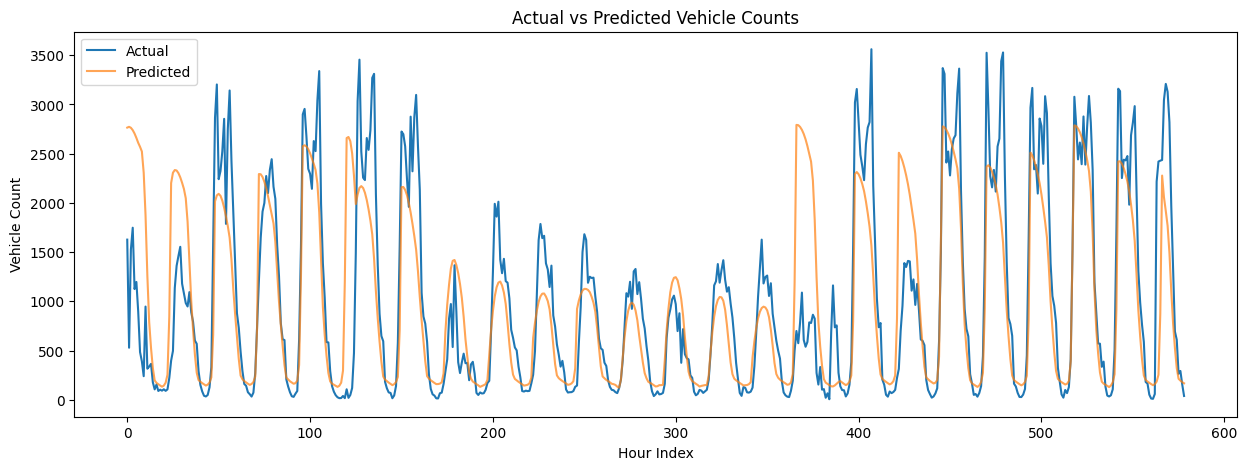

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_test = model.predict(X_test)

# inverse transform to get the actual vehicle counts
y_test_actual = scaler.inverse_transform(y_test)
y_pred_test_actual = scaler.inverse_transform(y_pred_test)

# performance metrics
mae = mean_absolute_error(y_test_actual, y_pred_test_actual)
mse = mean_squared_error(y_test_actual, y_pred_test_actual)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred_test_actual)
print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)
print('R-squared (R²):', r2)

# actual vs predicted vehicle counts
plt.figure(figsize=(15, 5))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred_test_actual, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Vehicle Counts')
plt.xlabel('Hour Index')
plt.ylabel('Vehicle Count')
plt.legend()
plt.show()

In [33]:
if len(test_hourly) > len(y_pred_test_actual):
    test_hourly = test_hourly.iloc[-len(y_pred_test_actual):].reset_index(drop=True) #sligght size mismatch

# new df w/ actual and predicted counts
test_hourly['actual_counts'] = y_test_actual.flatten()
test_hourly['predicted_counts'] = y_pred_test_actual.flatten()

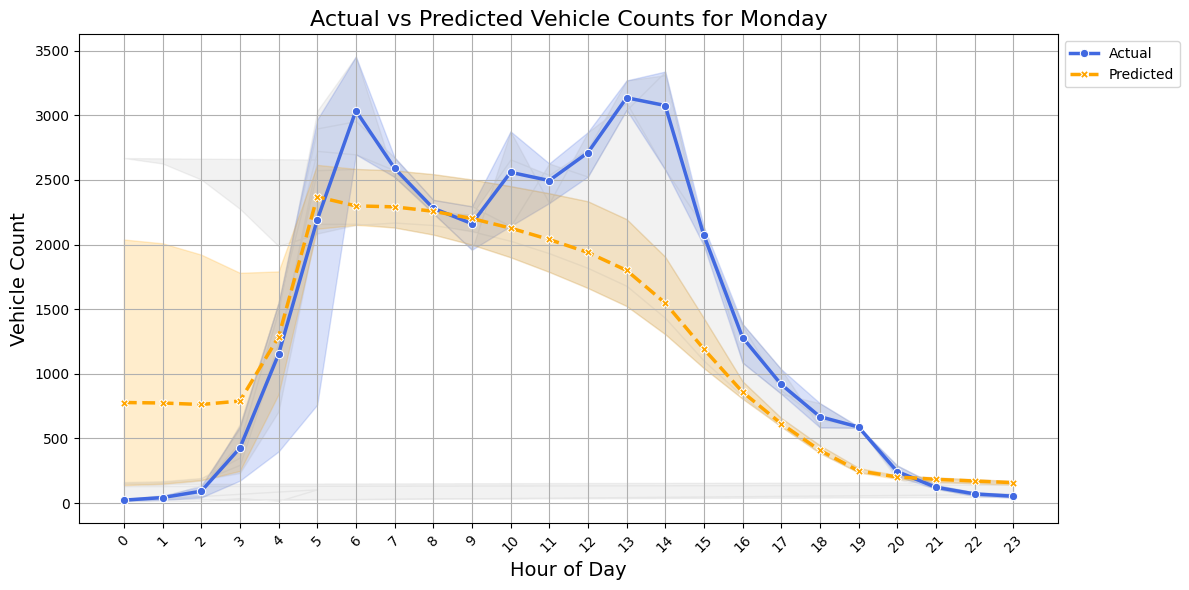

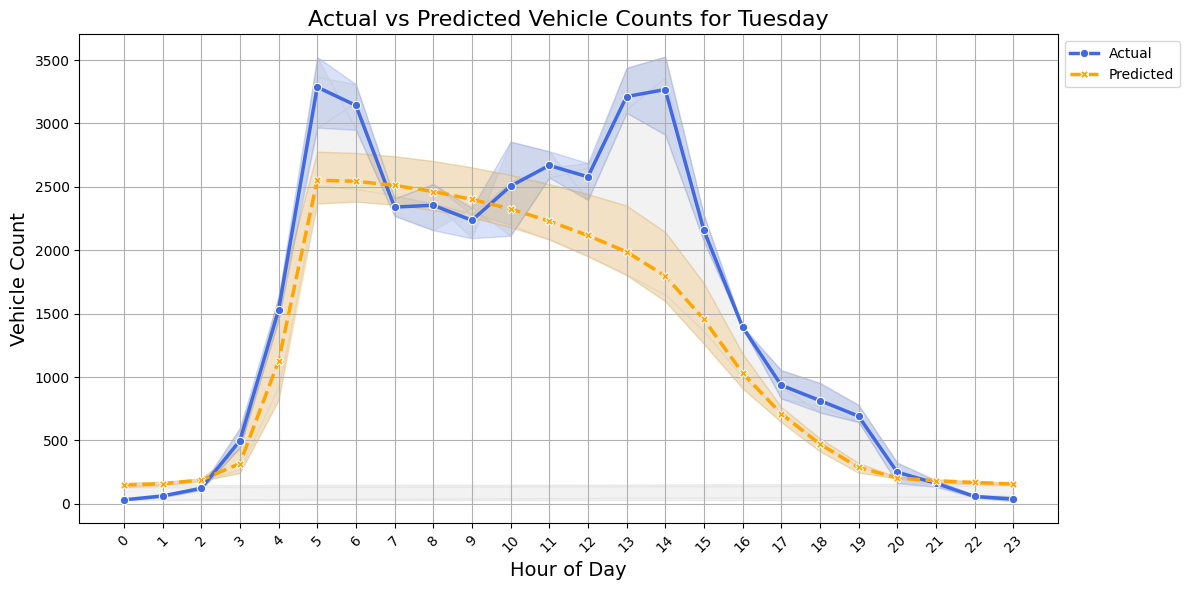

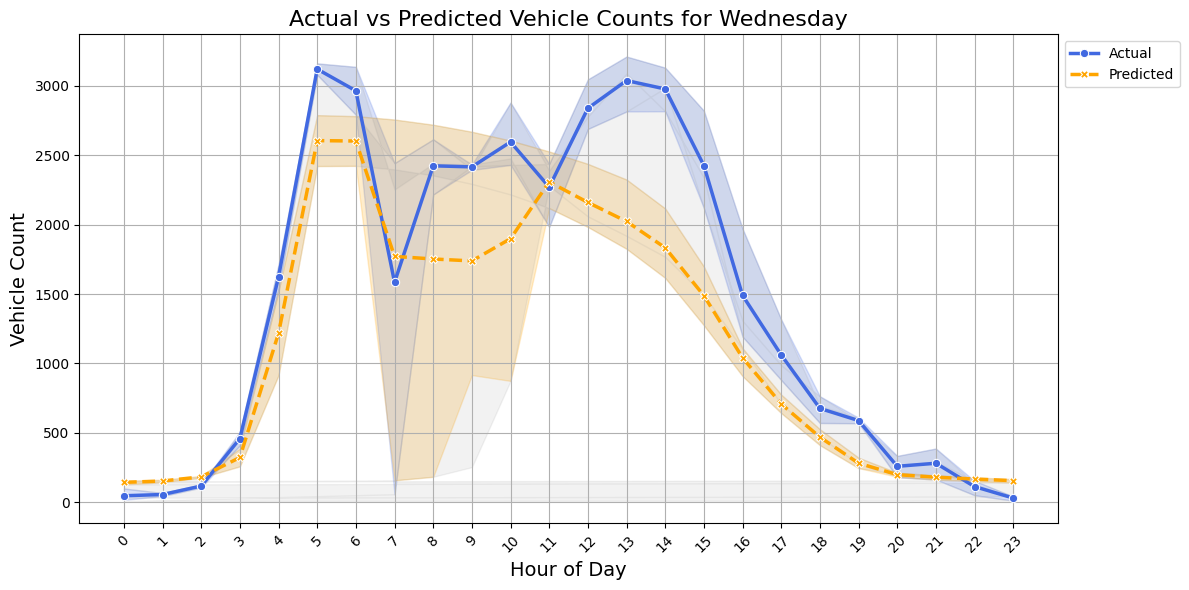

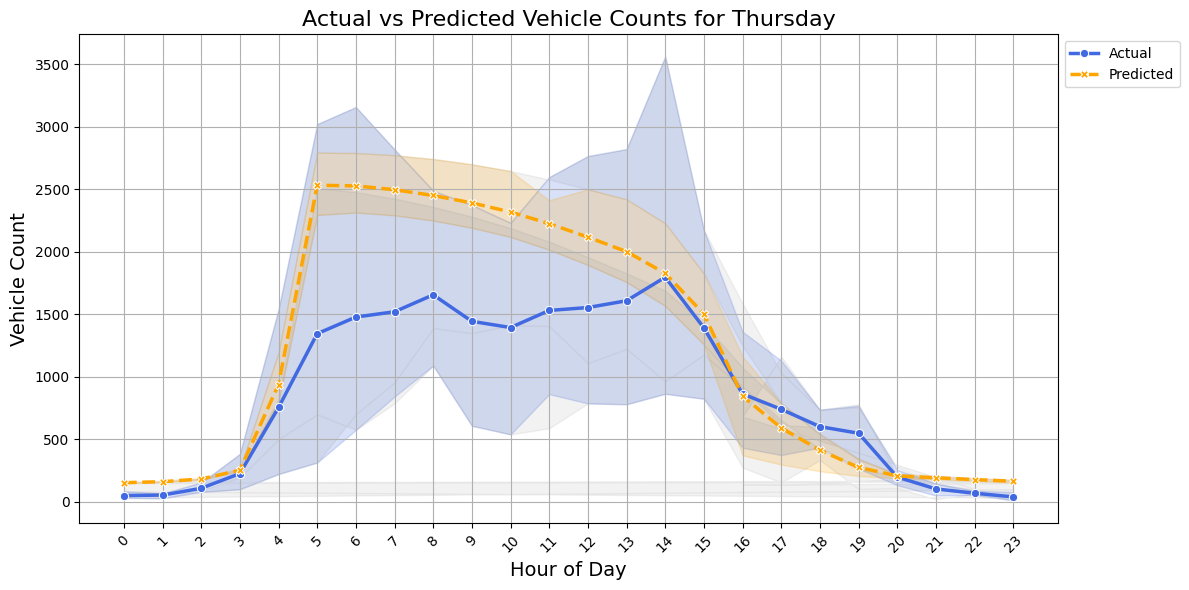

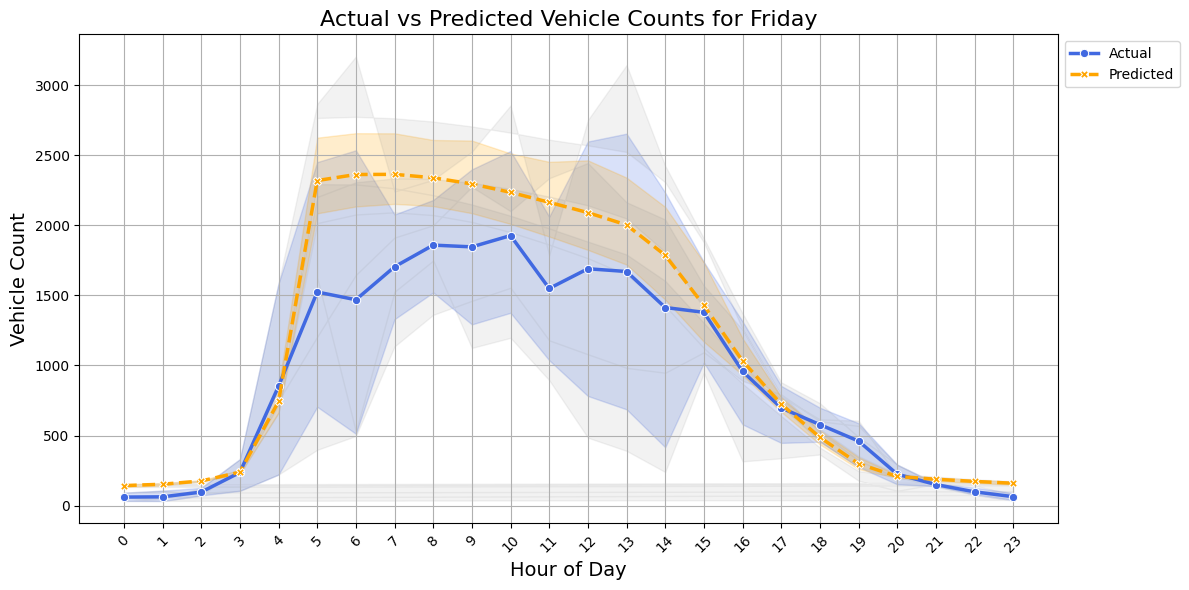

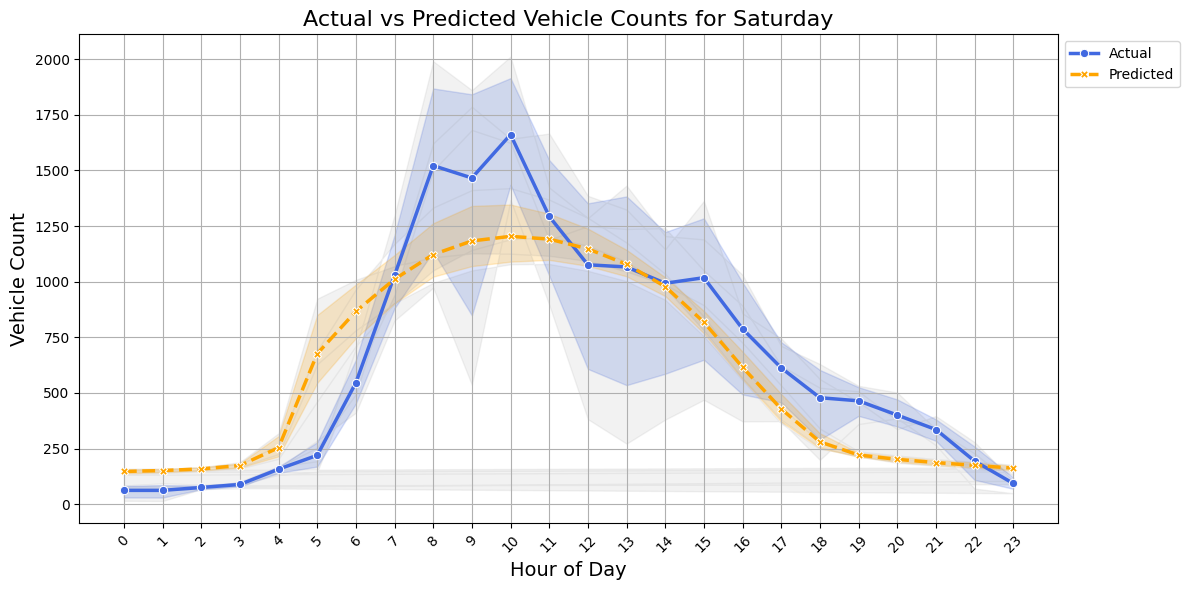

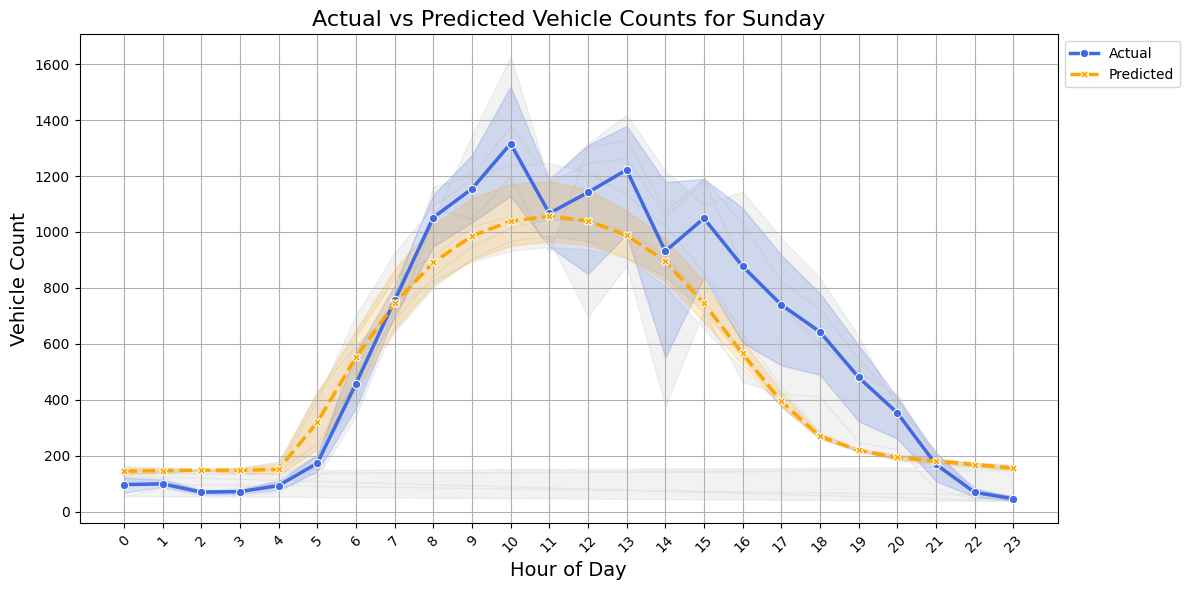

In [38]:
# Plot for each day
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for day in days_of_week:
    plt.figure(figsize=(12, 6))
    day_data = test_hourly[test_hourly['Day'] == day]

    # Plot actual vs predicted counts with enhancements
    sns.lineplot(data=day_data, x='Hour', y='actual_counts', label='Actual',
                 marker='o', linewidth=2.5, linestyle='-', color='royalblue')
    sns.lineplot(data=day_data, x='Hour', y='predicted_counts', label='Predicted',
                 marker='X', linewidth=2.5, linestyle='--', color='orange')

    plt.fill_between(day_data['Hour'], day_data['actual_counts'], day_data['predicted_counts'],
                     color='grey', alpha=0.1)

    plt.title(f'Actual vs Predicted Vehicle Counts for {day}', fontsize=16)
    plt.xlabel('Hour of Day', fontsize=14)
    plt.ylabel('Vehicle Count', fontsize=14)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.xticks(range(0, 24, 1), rotation=45)
    plt.tight_layout()
    plt.show()


# Save Stuff

In [35]:
model.save('/content/drive/MyDrive/IoT_Project/RealCounts.keras')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/IoT_Project/RealCounts.keras')

In [39]:
# saving chart data to csv and excel file
csv_file_path = '/content/drive/MyDrive/IoT_Project/new_predicted_vehicle_counts.csv'
test_hourly.to_csv(csv_file_path, index=False)

excel_file_path = '/content/drive/MyDrive/IoT_Project/new_predicted_vehicle_counts.xlsx'
test_hourly.to_excel(excel_file_path, index=False)